## Name : Tirth Hihoriya
## Roll no : 18BCE244
## Prac- 5 : CIFAR10 Transfer learning using generator

In [1]:
import tensorflow
from tensorflow import keras
import cv2
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()
print("X_train -> ",X_train.shape)
print("y_train -> ",y_train.shape)
print("X_test  -> ",X_test.shape)
print("y_test  -> ",y_test.shape)

X_train ->  (50000, 32, 32, 3)
y_train ->  (50000, 1)
X_test  ->  (10000, 32, 32, 3)
y_test  ->  (10000, 1)


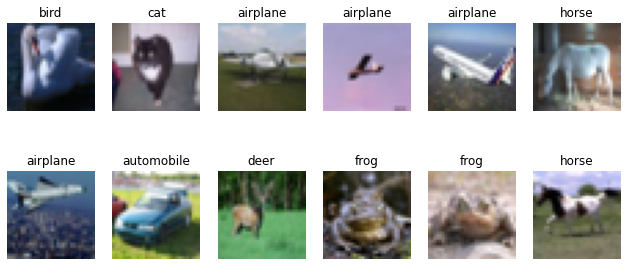

In [3]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_train_s = y_train.reshape(-1,)
y_test_s = y_test.reshape(-1,)
cols = 6
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :])
        label =  classes[y_train_s[random_index]]
        ax.set_title(label)
plt.show()

# Xception model


In [4]:
model_pretrained = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(72,72,3), pooling=None)

In [5]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=model_pretrained.output_shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 133,546
Trainable params: 133,546
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Generator function

In [7]:
def generator_func(x1,y1,BATCH_SIZE, total_size, name):
    i = 0
    while True:
        if i > total_size:
          i = 0
        x = np.array([cv2.resize(j, dsize=(72,72)) for j in x1[i:i+BATCH_SIZE, ...]]).astype('float32')
        x = preprocess_input(x)
        x = model_pretrained.predict(x)
        y = to_categorical(y1[i:i+BATCH_SIZE, ...], 10)
        i += BATCH_SIZE
        yield np.asarray(x), np.asarray(y)


In [8]:
batch_size = 32
train_gen = generator_func(X_train, y_train, batch_size, 50000, "train")
test_gen = generator_func(X_test, y_test, batch_size, 10000, "test")

train_gen

<generator object generator_func at 0x7f3d71772a50>

In [19]:
history = model.fit(train_gen, epochs=30,
                    steps_per_epoch=50000 // batch_size)

Epoch 1/30
1562/1562 [==============================] - 88s 57ms/step - loss: 0.6418 - accuracy: 0.7738
Epoch 2/30
1562/1562 [==============================] - 88s 56ms/step - loss: 0.6215 - accuracy: 0.7804
Epoch 3/30
1562/1562 [==============================] - 88s 56ms/step - loss: 0.6018 - accuracy: 0.7868
Epoch 4/30
1562/1562 [==============================] - 89s 57ms/step - loss: 0.5885 - accuracy: 0.7921
Epoch 5/30
1562/1562 [==============================] - 88s 56ms/step - loss: 0.5765 - accuracy: 0.7949
Epoch 6/30
1562/1562 [==============================] - 89s 57ms/step - loss: 0.5631 - accuracy: 0.7986
Epoch 7/30
1562/1562 [==============================] - 89s 57ms/step - loss: 0.5525 - accuracy: 0.8038
Epoch 8/30
1562/1562 [==============================] - 89s 57ms/step - loss: 0.5449 - accuracy: 0.8046
Epoch 9/30
1562/1562 [==============================] - 90s 57ms/step - loss: 0.5316 - accuracy: 0.8089
Epoch 10/30
1562/1562 [==============================] - 90s 57m

In [20]:
scores = model.evaluate(test_gen, steps=10000 // batch_size, verbose=1)
print("Accuracy :", scores[1])
print("Test Loss :", scores[0])


78/78 [==============================] - 4s 57ms/step - loss: 0.8824 - accuracy: 0.7444
Accuracy : 0.7443910241127014
Test Loss : 0.8824363946914673


In [21]:
def show_plots(history):
    loss_vals = history['loss']
    # val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle='-', label='Training Loss')
    # ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    # val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls='-', label='Training Accuracy')
    # ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()

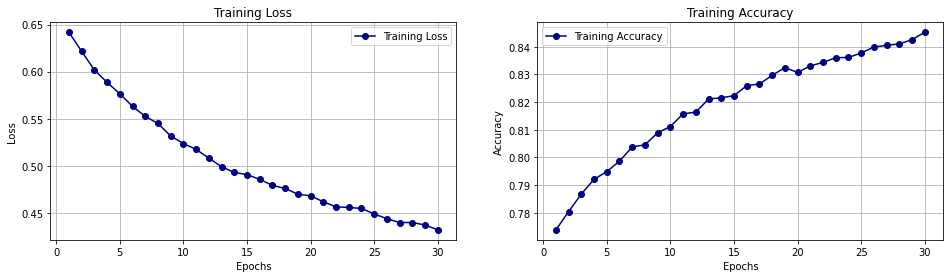

In [22]:
show_plots(history.history)